# Introduction

As a project in our Data Science journey, we had the task to analyze the Student Performance Data Set [(click here for the UCI Link)](https://archive.ics.uci.edu/ml/datasets/student+performance).

To summarize briefly, the data displays student performance of two Portuguese schools in secondary education. The grades are collected at three distinct times and are distinguished for subjects Mathematics and Portuguese. Data is expanded through many attributes such as `sex, age, studytime` etc. For a full description, please follow the link above.

Our task was not to create an application or deliver certain predictions, but rather compare and identify several prediction strategies. 
Mainly we want to know how well we can predict our **target**

`y = mean(grades)`

in three different scenarios:

* Scenario 1: 0 out of 3 numeric grades are present in the feature set.
* Scenario 2: 1 out of 3 numeric grades are present in the feature set.
* Scenario 3: 2 out of 3 numeric grades are present in the feature set.

Unless stated otherwise, all calucalations and figures are based on the  Mathematics part of the dataset.



# EDA

Let's have a brief look at our dataset and get a better feel for it.

In [225]:
################ IMPORTS
import pandas as pd
from sklearn import preprocessing
import plotly.graph_objects as go

################ DATA PREPARATION
# uncomment relevant filepath to analyze portugese data

# math
filepath = 'https://raw.githubusercontent.com/igoekce/aida-students-project/master/Data/Raw/student/student-mat.csv'
# portugese
# filepath = 'https://raw.githubusercontent.com/igoekce/aida-students-project/master/Data/Raw/student/student-por.csv'

df = pd.read_csv(filepath, sep=';')
df.columns = df.columns.str.lower()
# collect all binary columns
columns_binary = df.nunique().loc[df.nunique() == 2].index
# encdoe binary columns
dict_bin = { }
for column in columns_binary:
  lb = preprocessing.LabelBinarizer()
  df[column] = lb.fit_transform(df[column])
  dict_bin[column] = lb.classes_

df[columns_binary] = df[columns_binary].astype(bool)

################ DATA VIZUALIZATION
proportion_binary = (df[columns_binary].sum() / df[columns_binary].count() * 100).values
fig = go.Figure(data=[
    go.Bar(x=columns_binary, y=proportion_binary, marker_color='rgb(226,0,116)', hovertext=list(dict_bin.values())),
    go.Bar(x=columns_binary, y=100 - proportion_binary, marker_color='rgb(75,75,75)', hovertext=list(dict_bin.values()))
])
# Change the bar mode
fig.update_layout()

fig.update_layout(barmode='stack',
                  title_text='Distribution of binary attributes',
                  plot_bgcolor='rgba(0,0,0,0)',
                  showlegend=False)
fig.show()

Magenta label (grey in brackets)

- `school`: Mousinho da Silveira (Gabriel Pereira)
- `sex`: Male (Female)
- `address`: Urban (Rural)
- `famsize`: Less or equal than 3 (Greater than 3)
- `pstatus`: living together (apart)
- `schoolsup, famsup, paid, activities, nursery, higher, internet, romantic`: yes (no)

Some interesting insights regarding our task:

1. 95% of the students want to pursue higher education
2. 45% of the students have paid classes to support their education.

Further Insights we tried to gain through the correlation heatmap:

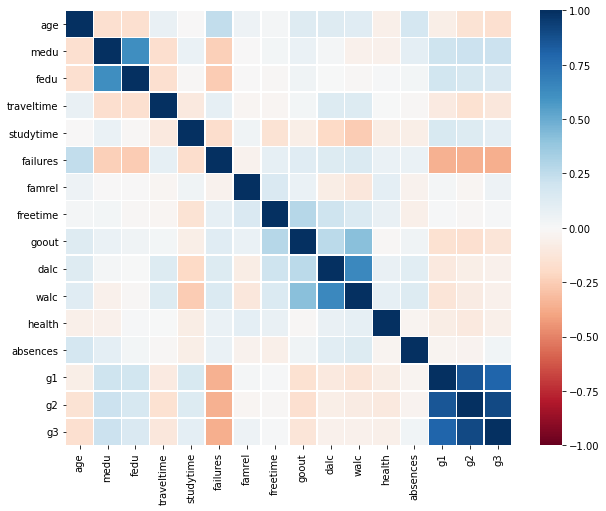

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=int).corr(),
            linewidths=.5,
            cmap="RdBu",
            vmin=-1,
            vmax=1);

The heatmap has three distinct spots we would like to comment on:

1. Education level of the parents seems to be somewhat correlated. This is interesting when you follow discussions regarding education level of parents and how this correlates with educational performance of their children.
2. Daily alcohol consumption is correlated with weekly alcohol consumption and both are (although slightly less) correlated with how often students go out with their friends.
3. All three grades are highly correlated with one another. The only other attribute which could be of importance seems to be failures (indicating previous class failures)

# Strategy

## Regression

### Baseline and Random Forest

First we conducted some data preprocessing (no missing or duplicate values were present), in particular binary encoding and one hot encoding all relevant variables.

Afterwards we proceeded as follows:

1. Establishing a linear regression baseline and calcualate cross validation scores `cv=5` on all three subtasks.
2. See whether can improve on our metric R-squared with a Random Forest Regressor.
3. Check and interpret the `feature_importances_` attribute of our models to be able to answer the question.

In [227]:
df = pd.get_dummies(df, drop_first=True)

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# distinguishing the cases
list_X = [df.drop(['g1', 'g2', 'g3'], axis =1),
          df.drop(['g2','g3'], axis = 1),
          df.drop('g3', axis=1)]
y = df[['g1', 'g2', 'g3']].mean(axis=1)  

In [229]:
scores_lin = []
for X in list_X:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
  lr = LinearRegression()
  scores_lin.append(cross_val_score(lr, X_train, y_train).mean())

In [230]:
scores_rfr = []
for X in list_X:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
  rfr = RandomForestRegressor()
  scores_rfr.append(cross_val_score(rfr, X_train, y_train).mean())

In [231]:
################ DATA VIZUALIZATION
fig = go.Figure(data=[
    go.Bar(name='Linear Regression', x=list(range(1, 4)), y=scores_lin, marker_color='rgb(75,75,75)'),
    go.Bar(name='Random Forest Regression', x=list(range(1, 4)), y=scores_rfr, marker_color='rgb(226,0,116)')
])
# Change the bar mode
fig.update_layout()

fig.update_layout(title_text='Cross validation scores per scenario per model family',
                  plot_bgcolor='rgba(0,0,0,0)',
                  showlegend=True,
                  xaxis_title='Scenario',
                  yaxis_title='R-squared')
fig.show()

When using Linear Regression as a baseline model, we can see that our cross validation score is slightly negative for our first scenario (when there are no numeric grades present in the feature set).

We can also see that once we introduce a single grade, the score scyrockets and with the second grade introduced, scratches a perfect prediction. 

The Random Forest Regressor is able to produce a small positive number in the first scenario, albeit still too low to use it in a productive session.

Scores in the second and third scenario are also higher than in the baseline configuration, yet differences are minorish (~4% and ~1% for second and third scenario respectively).

In [232]:
pip install dtreeviz

### Decision Tree

Scenario 1 Decision Tree

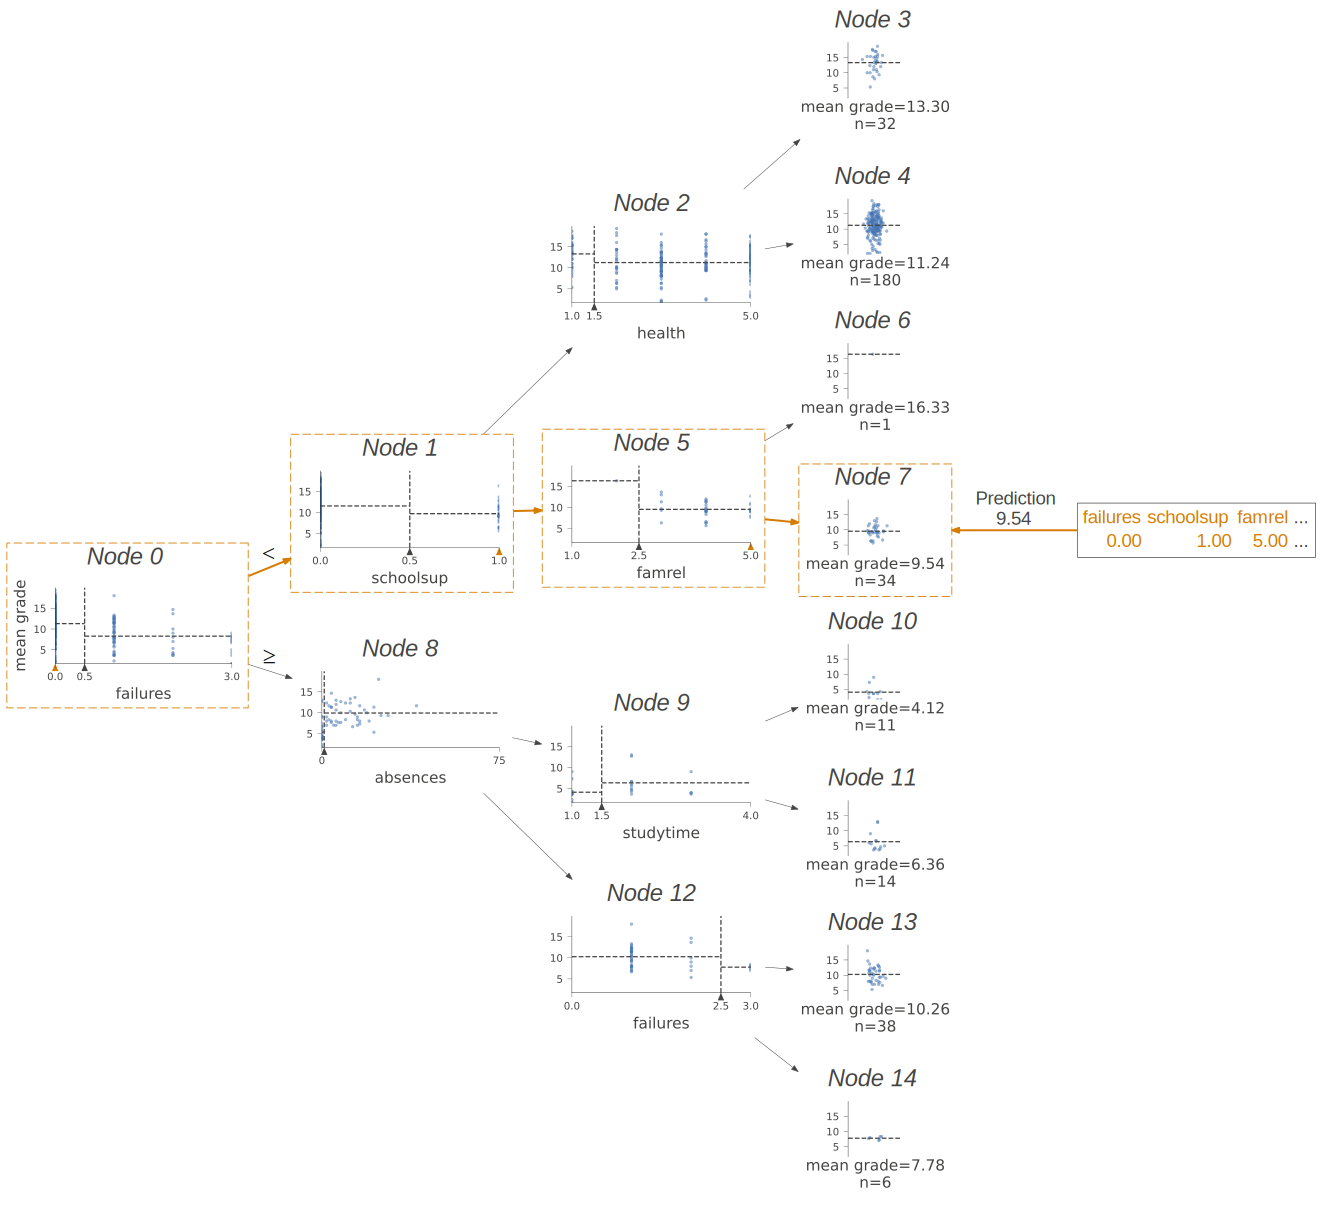

In [233]:
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(list_X[0], y, test_size = .2, random_state = 42)
dtr = DecisionTreeRegressor(max_depth=3, random_state=42)
dtr.fit(X_train, y_train)
viz = dtreeviz(dtr, X_train, y_train,
               target_name='mean grade', label_fontsize=12,
               show_node_labels=True,
               scale=1.7, orientation='LR',
               X=X_train.iloc[105], feature_names=X_train.columns)
viz  

To better visualize the underlying process, we decided to show a decision tree. For clarity we chose `max_depth=3` and will only present scenarios 1 and 2.

So we can see that the features used like `failures` and `schoolsup` are used in the regression model. Also the orange path depicts a random sample and how it would have fared in our decision tree.

Scenario 2 Decision Tree

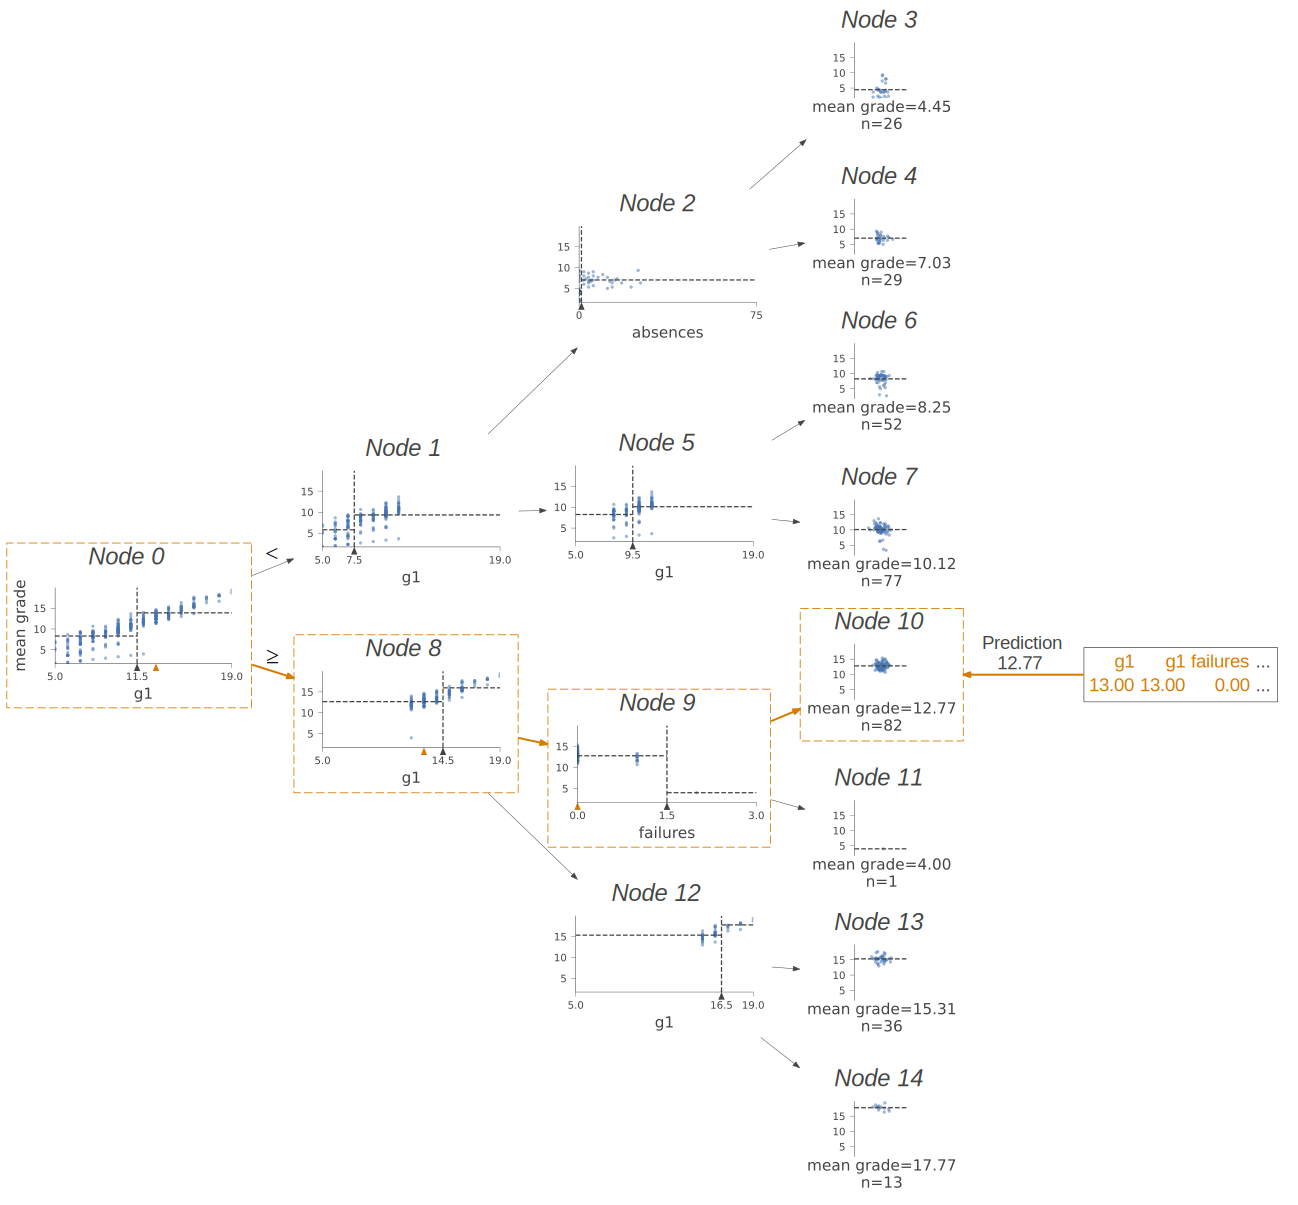

In [234]:
X_train, X_test, y_train, y_test = train_test_split(list_X[1], y, test_size = .2, random_state = 42)
dtr = DecisionTreeRegressor(max_depth=3, random_state=42)
dtr.fit(X_train, y_train)
viz = dtreeviz(dtr, X_train, y_train,
               target_name='mean grade', label_fontsize=12,
               show_node_labels=True,
               scale=1.7, orientation='LR',
               X=X_train.iloc[105], feature_names=X_train.columns)
viz 

In contrast, once we introduce a single grade (`g1`) nearly all nodes are relying on this feature (with only node 2 and 9 being exemptions). 

### Grid Search

We were curios how much we could improve our score in the first scenario with a grid search.

In [235]:
param_grid = {
    'max_depth': range(5, 30, 5),
    'n_estimators': range(50, 300, 50)
    }

In [236]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(list_X[0], y, test_size = .2, random_state = 42)

grid_search = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    verbose = 2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   35.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [237]:
grid_search.best_score_

0.19726489919736545

Our Grid Search returned a best score of **0.20** which is not a substantial increase compared to our non-tuned random forest.

### Feature Selection

So, we were still a bit curious and wanted to double check, how exactly the features resonate with our target variable. We therefore decided to condlude a feature selection and compare it with the `feature_importances_` attribute of our forest.

In [238]:
# numerical columns
X_num = df[['age', 'absences', 'g1', 'g2', 'g3']]
# categorial columns
X_cat = df.drop(['age', 'absences', 'g1', 'g2', 'g3'], axis=1).astype('category')

In [239]:
X_num['target'] = y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



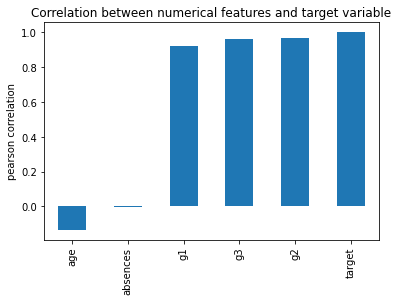

In [240]:
X_num.corr()['target'].sort_values().plot(kind='bar')
plt.title('Correlation between numerical features and target variable')
plt.ylabel('pearson correlation');

When target and input variables are numerical, pearson correlation can be used to identify the most important features. As expected results indicated that the grades are highly correlated with our target variables (*r* > 0.9).

In [241]:
from sklearn.feature_selection import SelectKBest, f_classif

skb_anova = SelectKBest(f_classif, k='all').fit(X_cat, y)
skb_anova.scores_
kbest_features_anova = pd.Series(skb_anova.scores_, X_cat.columns).sort_values(ascending=False)

In [242]:
kbest_features_anova.head(5)

failures         2.905916
fjob_teacher     1.743553
higher           1.733291
paid             1.534951
fjob_services    1.437876
dtype: float64

For the categorical features we opted to do a feature selection using the ANOVA test. As in the Decision Tree, we can see `failures` as a highly relevant feature. We were curious though just how similar the rankings of the features, so we decided to make a comparison.

In [243]:
X_train, X_test, y_train, y_test = train_test_split(list_X[0], y, test_size = .2, random_state = 42)
dtr = DecisionTreeRegressor(max_depth=9, random_state=42)
dtr.fit(X_train, y_train)

df_imp = pd.DataFrame(index=X_train.columns, data=dtr.feature_importances_)
df_imp.columns=['dt_importances']
df_imp_skbscore = pd.DataFrame(index=X_cat.columns, data=skb_anova.scores_) 
df_scores = df_imp.merge(df_imp_skbscore, left_index=True, right_index=True)
df_scores.columns=['dt_importances', 'skb_importances']
df_scores.corr().iloc[0]

dt_importances     1.000000
skb_importances    0.572766
Name: dt_importances, dtype: float64

Our *r* is 0.57 which is pretty substanstial, given the fact that we selected a random Decision Tree which also had access to non-categorical data. In conclusion although it is clear that previous performance is highly relevant for actual performance, the ranking of the categorical columns seems to be stable.

## Classification

In [244]:
# encoding target variable
y_enc = []
for i in y:
    if i < 9.5:
      y_enc.append(0)
    else:
      y_enc.append(1)

So, we have little success in predicting student performance without prior performance data, but what if we just want to know whether a student has *passed* or not. So we decided that for any mean grade 9 or lower that a student had *not passed*, while a grade 10 or higher meant that a student had *passed*. 

### Baseline and Random Forest Classifier

In [245]:
from sklearn.linear_model import LogisticRegression

scores_log = []
for X in list_X:
  X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size = .2, random_state = 42)
  clf_lr = LogisticRegression(max_iter=1000)
  scores_log.append(cross_val_score(clf_lr, X_train, y_train).mean())

In [246]:
from sklearn.ensemble import RandomForestClassifier

scores_rfc = []
for X in list_X:
  X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size = .2, random_state = 42)
  clf_rfc = RandomForestClassifier()
  scores_rfc.append(cross_val_score(clf_rfc, X_train, y_train).mean())

In [247]:
################ DATA VIZUALIZATION
fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=list(range(1, 4)), y=scores_log, marker_color='rgb(75,75,75)'),
    go.Bar(name='Random Forest Classifier', x=list(range(1, 4)), y=scores_rfc, marker_color='rgb(226,0,116)')
])
# Change the bar mode
fig.update_layout()

fig.update_layout(title_text='Cross validation scores per scenario per model family',
                  plot_bgcolor='rgba(0,0,0,0)',
                  showlegend=True,
                  xaxis_title='Scenario',
                  yaxis_title='Accuracy')
fig.show()

Alright! So once we change the question from *how good* a student is to whether a student is *good enough*, we achieve quite respectables scores, even in scenario 1.

### Confusion Matrix

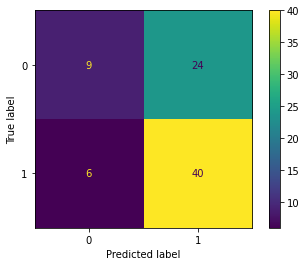

In [248]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(list_X[0], y_enc, test_size = .2, random_state = 42)
clf_rfc = RandomForestClassifier()
clf_rfc.fit(X_train, y_train)

plot_confusion_matrix(clf_rfc, X_test, y_test);

Looking at our confusion matrix, we can see that we have little cases where we miss someone who could pass (5 cases) but we often predict someone to pass, who in reality would not pass. So universities could use our model without grades as an upper bound, as usually less people will be passing anyway.

# Summary

**Conclusions:**

- Student's success is highly affected by previous performances.
- However, it is possible to achieve good predictions on student's success even without using previous grades G1, G2, when thinking of passed vs failed.
- Selection of features (e.g. SKB) or parameter gridsearch did not lead to major changes.
- Random Forest models slightly better than Linear or Logistic Regression models.

# Future Research & Lessons Learned

- Predictions without knowledge of previous grades require deeper insights into social and economic features (eg. income data, parents job and education, living environment)
- Desirable would be an investigation into different cluster of students with respect to their success at school
- Further analysis could help to improve the students' opportunities for more success in the eductional system!